In [2]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Logistic regression

### Plotting the data

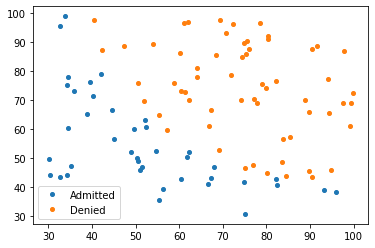

In [3]:
data = np.genfromtxt('data1.txt', delimiter=',')
good = data[np.where(data[:,2]==0)]
bad = data[np.where(data[:,2]==1)]
plt.plot(good[:,0], good[:,1], marker='o', markersize=4, ls='', label='Admitted')
plt.plot(bad[:,0], bad[:,1], marker='o', markersize=4, ls='', label='Denied')
plt.legend();

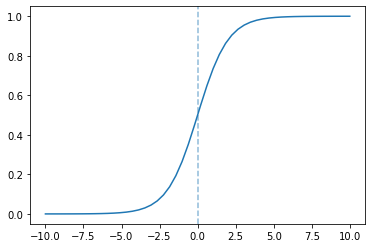

In [4]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

zp = np.linspace(-10,10,50)
plt.plot(zp, sigmoid(zp))
plt.axvline(0, ls='--', alpha=0.5);

### Cost function and gradient descent

In [29]:
def J(X,y,theta):
    n = len(y)
    h = sigmoid(np.dot(X, theta))
    j = -(np.dot(y,np.log(h))+np.dot(1-y,np.log(1-h)))
    j /= n
    grad = np.dot(X.T,(h-y))/n
    return j, grad

In [30]:
y = data[:,2]
X = np.ones_like(data)
X[:,[1,2]] = data[:,[0,1]]

cost, grad = J(X,y,[0,0,0])
print(cost, grad)
cost, grad = J(X,y,[-24, 0.2, 0.2])
print(cost, grad)

0.6931471805599451 [ -0.1        -12.00921659 -11.26284221]
0.2183301938265977 [0.04290299 2.56623412 2.64679737]


### Optimization using scipy

In [31]:
def Jmin(theta,X,y):
    j = J(X,y,theta)[0]
    return J(X,y,theta)[0]

def GradMin(theta,X,y):
    n = len(y)
    h = sigmoid(np.dot(X, theta))
    grad = np.dot(X.T,(h-y))/n
    return grad

In [33]:
import scipy.optimize as sco
m = sco.minimize(Jmin, x0=np.array([0., 0., 0.]), args=(X,y), method='Newton-CG', jac=GradMin)
thetas = m.x

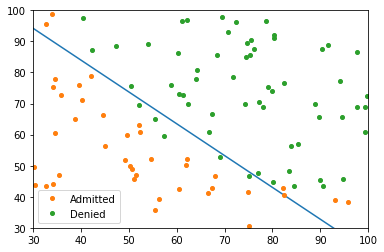

In [54]:
#Linear boundary condition is theta*x=0 -> x2 = (-theta_0-theta_1*x1)/theta_2
# xp1 = X[:,1]
xp1 = np.linspace(0,100,100)
xp2 = (-thetas[0]-thetas[1]*xp1)/thetas[2]
plt.plot(xp1, xp2)
plt.plot(good[:,0], good[:,1], marker='o', markersize=4, ls='', label='Admitted')
plt.plot(bad[:,0], bad[:,1], marker='o', markersize=4, ls='', label='Denied')
plt.xlim(30,100)
plt.ylim(30,100)
plt.legend();

### 2. Regularized logistic regression

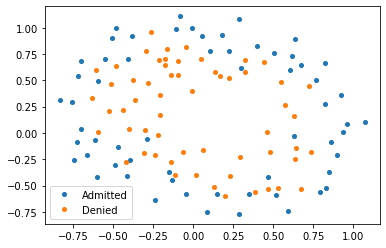

In [89]:
data2 = np.genfromtxt('data2.txt', delimiter=',')
good = data2[np.where(data[:,2]==0)]
bad = data2[np.where(data[:,2]==1)]
plt.plot(good[:,0], good[:,1], marker='o', markersize=4, ls='', label='Admitted')
plt.plot(bad[:,0], bad[:,1], marker='o', markersize=4, ls='', label='Denied')
plt.legend();

### Feature mapping

In [207]:
# Non linear boundary! Andrew suggests combination of power of each dimension up to 6
def mapFeature(x1,x2):
    d = 6
    X = np.zeros((len(x1),28))
    c = 0
    for n in range(d+1):
        for i in range(n+1):
            X[:,c] = x1**(n-i)*x2**(i)
            c += 1
    return X

### Cost function and gradient

In [192]:
def Jreg(X,y,theta,lamda):
    n = len(y)
    h = sigmoid(np.dot(X, theta))
    l = np.array([lamda]*(X.shape[1]))
    l[0]=0
    j = -(np.dot(y,np.log(h))+np.dot(1-y,np.log(1-h)))/n+np.dot(theta*l,theta)/(2*n)
    grad = np.dot(X.T,(h-y))/n+theta*l/n
    return j, grad

In [182]:
x1 = data2[:,0]
x2 = data2[:,1]
X = mapFeature(x1,x2)
y = data2[:,2]

cost, grads = Jreg(X,y,np.zeros(X.shape[1]),1)
cost, grads[:5]
for i in range(5):
    print(i, f"{grads[i]:.4f}")
    
print("--------")

cost, grads = Jreg(X,y,np.ones(X.shape[1]),10)
cost, grads[:5]
for i in range(5):
    print(i, f"{grads[i]:.4f}")

0 0.0085
1 0.0188
2 0.0001
3 0.0503
4 0.0115
--------
0 0.3460
1 0.1614
2 0.1948
3 0.2269
4 0.0922


### Optimization using scipy

In [193]:
def Jmin_reg(theta,X,y,lamda):
    n = len(y)
    h = sigmoid(np.dot(X, theta))
    l = np.array([lamda]*(X.shape[1]))
    l[0]=0
    j = -(np.dot(y,np.log(h))+np.dot(1-y,np.log(1-h)))/n+np.dot(theta*l,theta)/(2*n)
    return j

def GradMin_reg(theta,X,y,lamda):
    n = len(y)
    h = sigmoid(np.dot(X, theta))
    l = np.array([lamda]*(X.shape[1]))
    l[0]=0
    grad = np.dot(X.T,(h-y))/n+theta*l/n
    return grad

In [196]:
import scipy.optimize as sco
x1 = data2[:,0]
x2 = data2[:,1]
X = mapFeature(x1,x2)
y = data2[:,2]
m = sco.minimize(Jmin_reg, x0=np.zeros(X.shape[1]), args=(X,y,1), method='Newton-CG', jac=GradMin_reg)
m.fun, m.x[:5]

(0.5290027297130482,
 array([ 1.27274199,  0.62527138,  1.18108781, -2.01996111, -0.917423  ]))

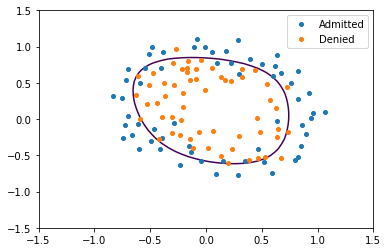

In [213]:
# thetaX now non-solvable... must map
thetas = m.x

x1l = np.linspace(-1.5,1.5,50)
x2l = np.linspace(-1.5,1.5,50)
xx1, xx2 = np.meshgrid(x1l,x2l)
y = np.zeros_like(xx1)

for i in range(x1l.shape[0]):
    for j in range(x1l.shape[0]):
        X = mapFeature(np.array([xx1[i][j]]),np.array([xx2[i][j]]))
        h = np.dot(X,thetas)
        y[i][j]=h
        
plt.contour(xx1, xx2, y, levels=[0])
good = data2[np.where(data[:,2]==0)]
bad = data2[np.where(data[:,2]==1)]
plt.plot(good[:,0], good[:,1], marker='o', markersize=4, ls='', label='Admitted')
plt.plot(bad[:,0], bad[:,1], marker='o', markersize=4, ls='', label='Denied')
plt.legend();

### Underfitting and overfitting

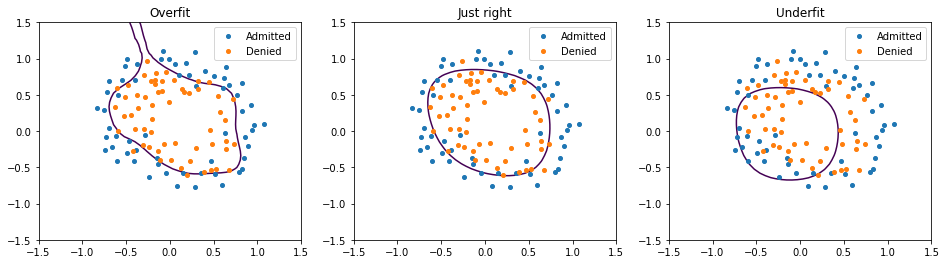

In [225]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
lambdas = [0,1,100]
titles = ["Overfit", "Just right", "Underfit"]
x1 = data2[:,0]
x2 = data2[:,1]
X = mapFeature(x1,x2)
y = data2[:,2]
for k, l in enumerate(lambdas):
    m = sco.minimize(Jmin_reg, x0=np.zeros(X.shape[1]), args=(X,y,l), method='Newton-CG', jac=GradMin_reg)
    thetas = m.x
    x1l = np.linspace(-1.5,1.5,50)
    x2l = np.linspace(-1.5,1.5,50)
    xx1, xx2 = np.meshgrid(x1l,x2l)
    yp = np.zeros_like(xx1)

    for i in range(x1l.shape[0]):
        for j in range(x1l.shape[0]):
            Xp = mapFeature(np.array([xx1[i][j]]),np.array([xx2[i][j]]))
            hp = np.dot(Xp,thetas)
            yp[i][j]=hp
            
    ax[k].contour(xx1, xx2, yp, levels=[0])
    good = data2[np.where(data[:,2]==0)]
    bad = data2[np.where(data[:,2]==1)]
    ax[k].plot(good[:,0], good[:,1], marker='o', markersize=4, ls='', label='Admitted')
    ax[k].plot(bad[:,0], bad[:,1], marker='o', markersize=4, ls='', label='Denied')
    ax[k].set_title(titles[k])
    ax[k].legend();